Theoretical Combined Mean (μ_c): 0.0
Theoretical Combined Std Dev (σ_c): 1.5811388300841898
Sample Combined Mean: -0.0001340824522304782
Sample Combined Std Dev: 2.5117144263712725
Prior: μ_0 = 0.0, λ_0 = 1.0, α_0 = 2.0, β_0 = 2.0
Cluster Means: [-2.0486016489663794, 1.8285142744904623]
Cluster Variances: [0.9242275835675491, 4.48366456577139]
Cluster Weights: [0.4475598932681053, 0.5524401067318947]
Gibbs Combined Mean: 0.09327268560004665
Gibbs Combined Std Dev: 2.5704615837312836
Comparison of Combined Parameters:
Theoretical Mean: 0.0, Theoretical Std Dev: 1.5811388300841898
Sample-Based Mean: -0.0001340824522304782, Sample-Based Std Dev: 2.5117144263712725
Gibbs Mean: 0.09327268560004665, Gibbs Std Dev: 2.5704615837312836


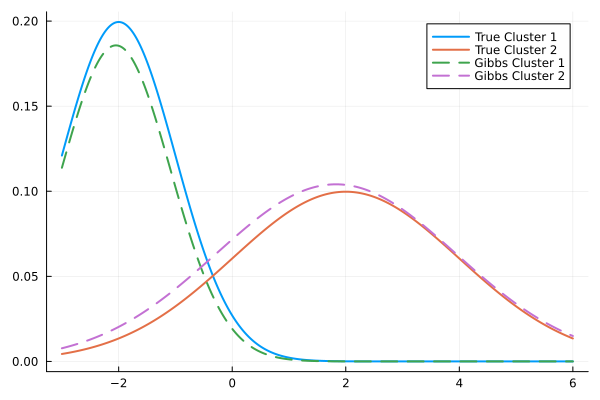

In [117]:
using Distributions, DataFrames, Statistics
include("gibbs_sampling.jl")

# Parameters for two distributions
μ_1, σ_1 = -2, 1  # Mean and standard deviation for cluster 1
μ_2, σ_2 = 2, 2  # Mean and standard deviation for cluster 2
N = 1000  # Total number of points (500 per cluster)

# Generate data
data_1 = rand(Normal(μ_1, σ_1), N ÷ 2)
data_2 = rand(Normal(μ_2, σ_2), N ÷ 2)
data = vcat(data_1, data_2)

# Theoretical combined parameters
μ_c = μ_1 / 2 + μ_2 / 2
σ_c = sqrt(0.5 * σ_1^2 + 0.5 * σ_2^2)

println("Theoretical Combined Mean (μ_c): ", μ_c)
println("Theoretical Combined Std Dev (σ_c): ", σ_c)

# Sample-based combined parameters
sample_mean = mean(data)
sample_std = std(data)

println("Sample Combined Mean: ", sample_mean)
println("Sample Combined Std Dev: ", sample_std)

# Assuming `gibbs_sampling` is your implemented function
K = 2  # Number of clusters
iterations = 1000
μ, σ², π, z = gibbs_sampling(data, K, iterations)

println("Cluster Means: ", μ)
println("Cluster Variances: ", σ²)
println("Cluster Weights: ", π)

# Combined mean from clusters
μ_gibbs = π[1] * μ[1] + π[2] * μ[2]

# Combined variance from clusters
σ²_gibbs = π[1] * (σ²[1] + (μ[1] - μ_gibbs)^2) +
           π[2] * (σ²[2] + (μ[2] - μ_gibbs)^2)

println("Gibbs Combined Mean: ", μ_gibbs)
println("Gibbs Combined Std Dev: ", sqrt(σ²_gibbs))


println("Comparison of Combined Parameters:")
println("Theoretical Mean: ", μ_c, ", Theoretical Std Dev: ", σ_c)
println("Sample-Based Mean: ", sample_mean, ", Sample-Based Std Dev: ", sample_std)
println("Gibbs Mean: ", μ_gibbs, ", Gibbs Std Dev: ", sqrt(σ²_gibbs))


using Plots

# Plot histogram of the data
#histogram(data, bins=30, density=true, label="Data", alpha=0.6)

# Plot the true distributions
x = range(-3, 6, length=1000)
plot(x, pdf.(Normal(μ_1, σ_1), x) / 2, label="True Cluster 1", lw=2)
plot!(x, pdf.(Normal(μ_2, σ_2), x) / 2, label="True Cluster 2", lw=2)

# Plot the Gibbs-sampled clusters
plot!(x, π[1] * pdf.(Normal(μ[1], sqrt(σ²[1])), x), label="Gibbs Cluster 1", lw=2, linestyle=:dash)
plot!(x, π[2] * pdf.(Normal(μ[2], sqrt(σ²[2])), x), label="Gibbs Cluster 2", lw=2, linestyle=:dash)

In [123]:
using DataFrames

# Theoretical combined parameters
theoretical_mean = μ_c
theoretical_std = σ_c

# Sample-based combined parameters
sample_combined_mean = sample_mean
sample_combined_std = sample_std

# Gibbs-sampled combined parameters
gibbs_combined_mean = μ_gibbs
gibbs_combined_std = sqrt(σ²_gibbs)

# Create a DataFrame for comparison
summary_df = DataFrame(
    Method = ["Theoretical", "Sample-Based", "Gibbs-Sampled"],
    Mean = [theoretical_mean, sample_combined_mean, gibbs_combined_mean],
    StdDev = [theoretical_std, sample_combined_std, gibbs_combined_std]
)

# Individual cluster parameters from Gibbs sampling
cluster_data = [
    ("Cluster 1", μ[1], sqrt(σ²[1])),
    ("Cluster 2", μ[2], sqrt(σ²[2]))
]

# Create the DataFrame

# Create the DataFrame
summary_df = DataFrame(
    Method = ["Theoretical", "Sample-Based", "Gibbs-Sampled", cluster_data[1][1], cluster_data[2][1]],
    Mean = [theoretical_mean, sample_combined_mean, gibbs_combined_mean, cluster_data[1][2], cluster_data[2][2]],
    StdDev = [theoretical_std, sample_combined_std, gibbs_combined_std, cluster_data[1][3], cluster_data[2][3]]
)

cluster_size_df=DataFrame(
    Cluster = ["Cluster 1", "Cluster 2"],
    Size = [sum(z .== 1), sum(z .== 2)],
    weight=[π[1],π[2]]
)

# Display the summary DataFrame
println(summary_df)
println(cluster_size_df)


5×3 DataFrame
 Row │ Method         Mean          StdDev   
     │ String         Float64       Float64  
─────┼───────────────────────────────────────
   1 │ Theoretical     0.0          1.58114
   2 │ Sample-Based   -0.000134082  2.51171
   3 │ Gibbs-Sampled   0.0932727    2.57046
   4 │ Cluster 1      -2.0486       0.961368
   5 │ Cluster 2       1.82851      2.11747
2×3 DataFrame
 Row │ Cluster    Size   weight  
     │ String     Int64  Float64 
─────┼───────────────────────────
   1 │ Cluster 1    456  0.44756
   2 │ Cluster 2    544  0.55244


Accuracy: 0.0


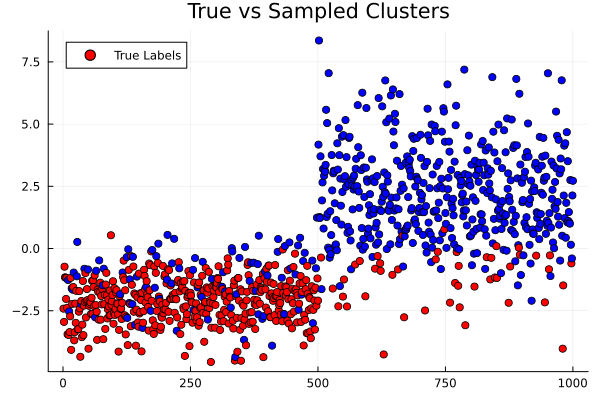

In [120]:
using Hungarian, StatsBase

# True labels and Gibbs-sampled labels
true_labels = vcat(fill(1, N ÷ 2), fill(2, N ÷ 2))  # True labels: half in cluster 1, half in cluster 2
sampled_labels = z  # Gibbs-sampled categorization

# Create confusion matrix
conf_matrix = zeros(Int, 2, 2)
for i in 1:length(z)
    conf_matrix[true_labels[i], sampled_labels[i]] += 1
end

# Find the best label alignment
assignment = hungarian(-conf_matrix)  # Minimize negative similarity

# Adjust sampled labels
adjusted_labels = [assignment[label] for label in sampled_labels]

# Compare true and adjusted labels
accuracy = mean(true_labels .== adjusted_labels)
println("Accuracy: ", accuracy)

using Plots
palette = [:red, :blue, :green]  # Add more colors if needed

#heatmap(conf_matrix, title="Confusion Matrix", xlabel="Sampled Clusters", ylabel="True Clusters")

scatter(1:N, data, color=palette[sampled_labels], label="True Labels", title="True vs Sampled Clusters")
#scatter!(1:N, data, color=palette[sampled_labels], label="Sampled Labels", markershape=:circle)
#using Clustering

#ari = adjusted_rand_index(true_labels, adjusted_labels)
#println("Adjusted Rand Index: ", ari)

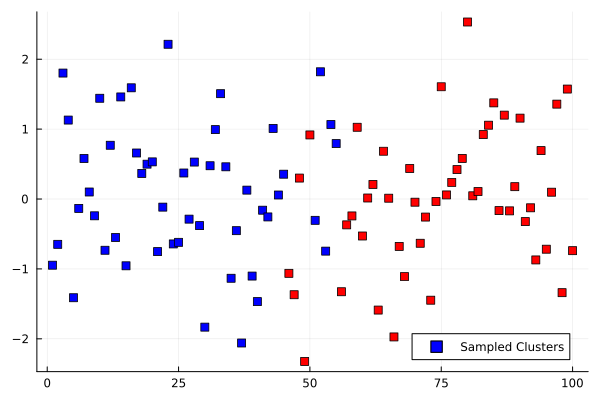

In [36]:
using Plots

# Data and cluster labels
data = randn(100)  # Example data points
true_labels = vcat(fill(1, 50), fill(2, 50))  # True cluster labels
sampled_labels = vcat(fill(2, 45), fill(1, 5), fill(2, 5), fill(1, 45))  # Sampled labels

# Define a color palette
palette = [:red, :blue, :green]  # Add more colors if needed

# Map cluster labels to colors
true_colors = palette[true_labels]
sampled_colors = palette[sampled_labels]

# Scatter plot
scatter(1:length(data), data, color=true_colors, label="True Clusters", title="True vs Sampled Clusters")
scatter(1:length(data), data, color=sampled_colors, label="Sampled Clusters", markershape=:square)

In [5]:
using Distributions

# Black-Scholes Greeks

# Black-Scholes Greeks
function black_scholes_greeks(S, K, T, r, σ, is_call=true)
    d1 = @. (log(S / K) + (r + 0.5 * σ^2) * T) / (σ * sqrt(T))
    d2 = @. d1 - σ * sqrt(T)
    nd1 = @. pdf(Normal(0, 1), d1)  # PDF of d1
    N_d1 = @. cdf(Normal(0, 1), d1)  # CDF of d1
    N_d2 = @. cdf(Normal(0, 1), d2)  # CDF of d2
    
    # Greeks
    delta = is_call ? N_d1 : @. N_d1 - 1
    gamma = @. nd1 / (S * σ * sqrt(T))
    vega = @. S * nd1 * sqrt(T)
    theta = @. (-(S * nd1 * σ) / (2 * sqrt(T)) - r * K * exp(-r * T) * (is_call ? N_d2 : -N_d2))
    rho = @. K * T * exp(-r * T) * (is_call ? N_d2 : -N_d2)

    return (delta=delta, gamma=gamma, vega=vega, theta=theta, rho=rho)
end

# Example usage
S = [100.0, 105.0]  # Spot prices
K = [100.0, 100.0]  # Strike prices
T = [1.0, 0.5]      # Time to maturity (years)
r = 0.05            # Risk-free rate
σ = [0.2, 0.25]     # Volatility
is_call = true      # True for calls, false for puts

greeks = black_scholes_greeks(S, K, T, r, σ, is_call)
println("Greeks: $greeks")

Greeks: (delta = [0.6368306511756191, 0.6935044726127116], gamma = [0.018762017345846895, 0.018912124071844904], vega = [37.52403469169379, 26.06327098651126], theta = [-6.414027546438197, -9.582846519315638], rho = [53.232481545376345, 30.67028772687824])


In [16]:
import Pkg; Pkg.add("Hungarian")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Hungarian ─ v0.7.0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [e91730f6] + Hungarian v0.7.0
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [e91730f6] + Hungarian v0.7.0
Precompiling project...
    545.9 ms  ✓ Hungarian
  1 dependency successfully precompiled in 2 seconds. 285 already precompiled.
